In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Concatenate,MaxPooling2D,Add,LSTM,BatchNormalization,TimeDistributed,Lambda,RepeatVector
from tensorflow.keras.layers import Flatten,Conv2D,Concatenate
from tensorflow.keras.layers import Embedding,Dropout
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from google.colab import drive
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import random
# from sklearn.preprocessing import MinMaxScaler4
from google.colab  import drive
import tensorflow.keras.backend as backend

# define documents


In [2]:
drive.mount('drive')

Mounted at drive


In [4]:
with open('drive/My Drive/Be project/img_data_5000_64.pickle','rb') as f:
  data_images,docs = pickle.load(f)

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-02-01 02:27:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-01 02:28:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-01 02:28:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
vocab_dict = {}
# for name in os.listdir('/content'):
#     if(name.endswith('.txt')):
#         print('\n Processing '+name+)
with open('/content/glove.6B.50d.txt','r') as f:
    f = list(f)
for line in tqdm(f):
    vocab_dict[line.split(' ')[0]] = [float(x) for x in line.split()[1:]]
    # for line in  ne)

100%|██████████| 400000/400000 [00:09<00:00, 42005.05it/s]


In [8]:
import string
import re 
table = str.maketrans('', '', string.punctuation)
encoded_docs = []
error_docs = []
for sentence in tqdm(enumerate(docs)):
    index,sentence = sentence
    sentence_list = []
    for word in re.split(r'[-,\s]\s*',sentence.lower()):
        word = word.translate(table)
        try:
            sentence_list.append(np.array(vocab_dict[word]))
        except:
            error_docs.append(index)
    encoded_docs.append(np.array(sentence_list))

5685it [00:00, 6345.93it/s]


In [9]:
data_images = list(data_images)
desc = []
images = []
for x in tqdm(range(len(encoded_docs))):
    if(x not in error_docs):
        desc.append(encoded_docs[x])
        images.append(data_images[x])

100%|██████████| 5685/5685 [00:00<00:00, 109095.24it/s]


In [10]:
length = [len(x) for x in desc ]
max_length = max(length)
print(max_length)
desc = np.array(desc)


75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [11]:
padded_doc = []
for x in desc:
    y =np.zeros((max_length-x.shape[0],50))
    padded_doc.append(np.concatenate([x,y],axis=0))


In [12]:
padded_doc = np.array(padded_doc)

In [13]:
padded_doc.shape

(5194, 75, 50)

In [14]:
tf.keras.backend.clear_session()

In [15]:
latent_dim = 512
height = 64
width = 64
channels = 3
# encoder.trainable = False

In [16]:
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [17]:
def MinibatchStdev(inputs):
		# calculate the mean value for each pixel across channels
	mean = backend.mean(inputs, axis=0, keepdims=True)
		# calculate the squared differences between pixel values and mean
	squ_diffs = backend.square(inputs - mean)
		# calculate the average of the squared differences (variance)
	mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
		# add a small value to avoid a blow-up when we calculate stdev
	mean_sq_diff += 1e-8
		# square root of the variance (stdev)
	stdev = backend.sqrt(mean_sq_diff)
		# calculate the mean standard deviation across each pixel coord
	mean_pix = backend.mean(stdev, keepdims=True)
		# scale this up to be the size of one input feature map for each sample
	shape = backend.shape(inputs)
	output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		# concatenate with the output
	combined = backend.concatenate([inputs, output], axis=-1)
	return combined


In [18]:
import tensorflow as tf
from tensorflow.keras import backend
def PixelWiseNormalization(inputs):
    values = inputs**2.0
    mean_values = backend.mean(values, axis=-1, keepdims=True)
    mean_values += 1.0e-8
    l2 = backend.sqrt(mean_values)
    normalized = inputs / l2
    return normalized

In [19]:
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import LeakyReLU,UpSampling2D,AveragePooling2D

encode_dense_shape = 128
const = max_norm(1.0)
intermediate_lay = []
generator_input_z = Input(shape=(latent_dim,))
generator_input_encode = Input(padded_doc.shape[1:])

z_dense = layers.Dense(2*4*512)(generator_input_z)
# z_dense = layers.BatchNormalization(momentum = 0.5)(z_dense)
z_dense = layers.LeakyReLU(0.2)(z_dense)

encode_dense = layers.Dense(2*4*512)(Flatten()(generator_input_encode))
# encode_dense = layers.BatchNormalization(momentum = 0.5)(encode_dense)
encode_dense = layers.LeakyReLU(0.2)(encode_dense)

x = Concatenate()([z_dense,encode_dense])
x = layers.Reshape((4,4,512))(x)
# x = layers.Conv2D(512,4,padding='same',use_bias=False,kernel_constraint = const)(x)
# x = Lambda(PixelWiseNormalization)(x)
# x = LeakyReLU(0.2)(x)
print(x.shape)
x = Conv2D(512,3,padding='same',use_bias=False,kernel_constraint = const)(x)
x = Lambda(PixelWiseNormalization)(x)
x = LeakyReLU(0.2)(x)
intermediate_lay.append(Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x))
x = UpSampling2D()(x)

encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(generator_input_encode))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])

# x = Conv2D(256,3,padding='same',use_bias=False,kernel_constraint = const)(x)
# x = Lambda(PixelWiseNormalization)(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(256,3,padding='same',use_bias=False,kernel_constraint = const)(x)
x = Lambda(PixelWiseNormalization)(x)
x = LeakyReLU(0.2)(x)
intermediate_lay.append(Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x))
x = UpSampling2D()(x)

# x = layers.Conv2DTranspose(64,7,padding='same',use_bias=False,strides = 1)(x)
# x = layers.BatchNormalization(momentum = 0.9)(x)
# x = layers.LeakyReLU(0.4)(x)
encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(generator_input_encode))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])

# x = Conv2D(128,3,padding='same',use_bias=False,kernel_constraint = const)(x)
# x = Lambda(PixelWiseNormalization)(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(128,3,padding='same',use_bias=False,kernel_constraint = const)(x)
x = Lambda(PixelWiseNormalization)(x)
x = LeakyReLU(0.2)(x)
intermediate_lay.append(Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x))
x = UpSampling2D()(x)

# x = layers.Conv2DTranspose(128,7,padding='same',use_bias=False,strides = 1)(x)
# x = layers.BatchNormalization(momentum = 0.9)(x)
# x = layers.LeakyReLU(0.4)(x)
encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(generator_input_encode))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])

# x = Conv2D(64,3,padding='same',use_bias=False,kernel_constraint = const)(x)
# x = Lambda(PixelWiseNormalization)(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(64,3,padding='same',use_bias=False,kernel_constraint = const)(x)
x = Lambda(PixelWiseNormalization)(x)
x = LeakyReLU(0.2)(x)
intermediate_lay.append(Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x))
x = UpSampling2D()(x)

# x = layers.Conv2DTranspose(64,7,padding='same',use_bias=False,strides = 1)(x)
# x = layers.BatchNormalization(momentum = 0.9)(x)
# x = layers.LeakyReLU(0.4)(x)
encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(generator_input_encode))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])

# x = Conv2D(32,3,padding='same',use_bias=False,kernel_constraint = const)(x)
# x = Lambda(PixelWiseNormalization)(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(32,4,padding='same',use_bias=False,kernel_constraint = const)(x)
x = Lambda(PixelWiseNormalization)(x)
x = LeakyReLU(0.2)(x)
# intermediate_lay.append(Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x))
# x = UpSampling2D()(x)

x = Conv2D(3,1,padding='same',activation='sigmoid',kernel_constraint = const,use_bias=False)(x)



(None, 4, 4, 512)


In [20]:
generator = tf.keras.Model([generator_input_z,generator_input_encode],[x,intermediate_lay[-1],intermediate_lay[-2],intermediate_lay[-3],intermediate_lay[-4]],name='generator')
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 50)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 3750)         0           ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 4096)         2101248     ['input_1[0][0]']                
                                                                                          

In [21]:
generator.output

[<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'conv2d_9')>,
 <KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_7')>,
 <KerasTensor: shape=(None, 16, 16, 3) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 8, 8, 3) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 4, 4, 3) dtype=float32 (created by layer 'conv2d_1')>]

In [22]:
from tensorflow.keras.layers import LeakyReLU,UpSampling2D,AveragePooling2D
discriminator_input = layers.Input(shape=(height, width, channels))
discriminator_input_encode = Input(padded_doc.shape[1:])
disc_32 = Input((32,32,3))
disc_16 = Input((16,16,3))
disc_8 = Input((8,8,3))
disc_4 = Input((4,4,3))
encode_out = discriminator_input_encode
# encode_out = encoder(discriminator_input_encode)
disc_encode_dense = Dense(128,kernel_constraint = const)(Flatten()(encode_out))
# x = layers.BatchNormalization(momentum = 0.9)(x)
disc_encode_dense= layers.LeakyReLU(0.2)(disc_encode_dense)

x = Conv2D(32,3,padding="same",kernel_constraint = const,use_bias=False)(discriminator_input)
# x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
# x = Conv2D(32,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU(0.2)(x)
x = AveragePooling2D()(x)


encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(disc_encode_dense))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])
x = Concatenate()([x,disc_32])
x = Lambda(MinibatchStdev)(x)
# x = Conv2D(64,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(64,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D()(x)



encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(disc_encode_dense))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])
x = Concatenate()([x,disc_16])
x = Lambda(MinibatchStdev)(x)
# x = Conv2D(128,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(128,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D()(x)



encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(disc_encode_dense))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])
x = Concatenate()([x,disc_8])
x = Lambda(MinibatchStdev)(x)
# x = Conv2D(256,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(256,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = AveragePooling2D()(x)


encode_dense = layers.Dense(x.shape[1]*x.shape[2])(Flatten()(disc_encode_dense))
encode_dense = layers.LeakyReLU(0.2)(encode_dense)
reshape_x = layers.Reshape((x.shape[1],x.shape[2],1))(encode_dense)
x = Concatenate()([x,reshape_x])
x = Concatenate()([x,disc_4])
x = Lambda(MinibatchStdev)(x)

# x = Conv2D(512,3,padding="same",kernel_constraint = const,use_bias=False)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU(0.2)(x)
x = Conv2D(512,4,padding="same",kernel_constraint = const,use_bias=False)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Lambda(MinibatchStdev)(x)


x = Flatten()(x)
x = layers.Concatenate()([x,disc_encode_dense])


x = Dense(4*5*250,kernel_constraint = const)(x)
# x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
# x = Dense(128)(x)
# # x = layers.BatchNormalization(momentum = 0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
x = Dense(1,activation = 'linear',kernel_constraint = const)(x)



In [23]:
discriminator = tf.keras.Model([discriminator_input,discriminator_input_encode,disc_32,disc_16,disc_8,disc_4],x,name='discriminator')
# disc_optimizer = tf.keras.optimizers.RMSprop(lr=0.00009)
# disc_optimizer = tf.keras.optimizers.Adam(lr=0.000005, beta_1=0, beta_2=0.99, epsilon=10e-8)
# disc_optimizer = tf.keras.optimizers.Adam(lr=0.000003)

disc_optimizer = tf.keras.optimizers.RMSprop(lr=0.0009)


discriminator.compile(loss=wasserstein_loss,optimizer=disc_optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
discriminator.trainable = False
gan_input_z = Input(shape=(latent_dim,))
gan_input_encode = Input(padded_doc.shape[1:])
gen_out,gen_32,gen_16,gen_8,gen_4= generator([gan_input_z,gan_input_encode])
print(x.shape)
gan_output = discriminator([gen_out,gan_input_encode,gen_32,gen_16,gen_8,gen_4])
gan = Model([gan_input_z,gan_input_encode], gan_output,name='gan')
# tinker different optimizer and learning rate 
gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0007)
# gan_optimizer = tf.keras.optimizers.Adam(lr=0.000009, beta_1=0, beta_2=0.99, epsilon=10e-8)
# gan_optimizer = tf.keras.optimizers.Adam(lr=0.0009)

# gan_optimizer = tf.keras.optimizers.Adam(lr=0.009)

gan.compile(optimizer=gan_optimizer, loss=wasserstein_loss)

(None, 1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [25]:
gan.summary()

Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 75, 50)]     0           []                               
                                                                                                  
 generator (Functional)         [(None, 64, 64, 3),  41818656    ['input_9[0][0]',                
                                 (None, 32, 32, 3),               'input_10[0][0]']               
                                 (None, 16, 16, 3),                                               
                                 (None, 8, 8, 3),                                               

In [26]:
train_x = np.array(images)
train_padded_docs = padded_doc
print('images = ',train_x.shape)
print('text = ',train_padded_docs.shape)

images =  (5194, 64, 64, 3)
text =  (5194, 75, 50)


In [27]:
import cv2
batch_size = 32
iterations = int(train_x.shape[0]/batch_size)*10
# iterations =600
print('No of epochs = ',iterations)
# save_dir = 'your_dir'
start = 0
for step in range(iterations):
      stop = start + batch_size

      random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
      dense_vector = train_padded_docs[start: stop]
      generated_images = generator.predict([random_latent_vectors,dense_vector])
      
      discriminator.trainable = True

      real_images = train_x[start: stop]
    #   real_images_64 = np.array([cv2.resize(x,(64,64)) for x in real_images])
      real_images_32 = np.array([cv2.resize(x,(32,32)) for x in real_images])
      real_images_16 = np.array([cv2.resize(x,(16,16)) for x in real_images])
      real_images_8 = np.array([cv2.resize(x,(8,8)) for x in real_images])
      real_images_4 = np.array([cv2.resize(x,(4,4)) for x in real_images])
      real_labels = -np.ones((batch_size, 1))         #for wgan
#       print(real_labels.shape)

      real_labels += 0.05*np.random.random(real_labels.shape)
      real_d_loss = discriminator.train_on_batch([real_images,dense_vector,real_images_32,real_images_16,real_images_8,real_images_4], real_labels)

      gen_images = generated_images
    #   labels = np.zeros((batch_size, 1))
      labels = np.ones((batch_size,1))          #for wgan
      labels += 0.05*np.random.random(labels.shape)
      fake_d_loss = discriminator.train_on_batch([generated_images[0],dense_vector,generated_images[1],generated_images[2],generated_images[3],generated_images[4]], labels)
    #   d_loss = 0.5*d_loss
    #   x = train_padded_docs[np.random.choice(train_padded_docs.shape[0],int(batch_size/2))]
    #   y = train_x[np.random.choice(train_x.shape[0],int(batch_size/2))]

    #   labels = np.ones((int(batch_size/2),1))          #for wgan

    #   diff_d_loss = discriminator.train_on_batch([y,x],labels)
      discriminator.trainable = False  
      if(step%1 == 0):
        random_latent_vectors = np.random.normal(size=(batch_size*2,latent_dim))
        misleading_targets = -np.ones((batch_size*2, 1))
        #   misleading_targets += 0.05*np.random.random(misleading_targets.shape)
        random_desc =train_padded_docs[np.random.choice(train_padded_docs.shape[0],batch_size*2)]
            
        #   print(random_latent_vectors.shape)
        #   print(dense_vector.shape)
        #   print(misleading_targets.shape)
        a_loss = gan.train_on_batch([random_latent_vectors,random_desc],misleading_targets)

      start += batch_size

      if start > len(train_x) - batch_size:
        start = 0
      if step % 10 == 0:
    #     gan.save_weights('gan.h5')
        print('Epoch = ',step,' fake loss =', fake_d_loss ,' real loss =',real_d_loss,"gen loss = ",a_loss)
        # ,' diff_d_loss = ',diff_d_loss,
        # print('adversarial loss:', a_loss)

No of epochs =  1620
Epoch =  0  fake loss = 67.07463073730469  real loss = 0.0544784739613533 gen loss =  -16.29561996459961
Epoch =  10  fake loss = 15.376307487487793  real loss = -8.135184288024902 gen loss =  5.208819389343262
Epoch =  20  fake loss = -1.450505018234253  real loss = 0.9269260168075562 gen loss =  5.2778425216674805
Epoch =  30  fake loss = 1.6466296911239624  real loss = -0.7417340278625488 gen loss =  3.256953477859497
Epoch =  40  fake loss = 1.0250601768493652  real loss = -0.7242642641067505 gen loss =  3.170132637023926
Epoch =  50  fake loss = 3.1232824325561523  real loss = -2.48264217376709 gen loss =  0.9675047397613525
Epoch =  60  fake loss = 64.16426849365234  real loss = -34.90888214111328 gen loss =  -10.943010330200195
Epoch =  70  fake loss = -2.2321596145629883  real loss = -4.750673294067383 gen loss =  17.04312515258789
Epoch =  80  fake loss = 8.657605171203613  real loss = -15.324077606201172 gen loss =  2.973202705383301
Epoch =  90  fake los

In [28]:
#  for making a tile of different images
def make_example():
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 10
    rows = 10
    for i in range(1, columns*rows +1):
        latent_space = np.random.normal(size =(1,latent_dim))
        out_put = generator.predict([latent_space,np.array([padded_doc[i]])])
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(out_put[0][0],interpolation='nearest')
        plt.axis('off')
        i = 1
        text = []
        # for x in docs[no].split(' '):
        #     if(i%9 == 0):
        #         text.append('\n')
        #     text.append(x)
        #     i = i +1
        # plt.xlabel(" ".join(text))
        # plt.tight_layout()
    plt.savefig('images.png',bbox_inches='tight')

    plt.show()

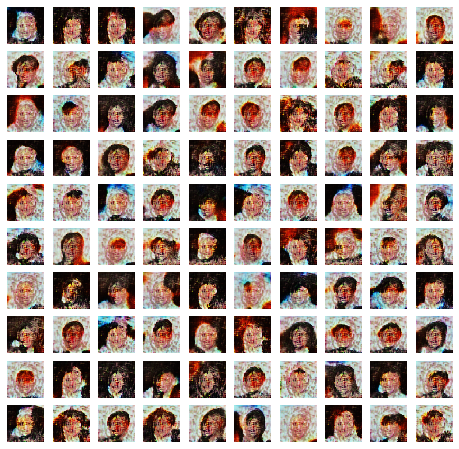

In [29]:
make_example()

(75, 50)


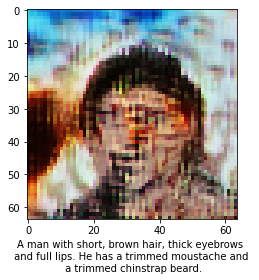

In [30]:
# generates  nth images from the dataset 
no = 12

latent_space = np.random.normal(size =(1,latent_dim))
print(padded_doc[no].shape)
out_put = generator.predict([latent_space,np.array([padded_doc[no]])])
# disc_out = discriminator.predict([np.array([train_x[no]]),np.array([padded_docs[no]])])
plt.imshow(out_put[0][0])

# print(disc_out)
# plt.text(20,73,docs[no])
# plt.gcf().text(0.02, 0.5, docs[no], fontsize=14)
i = 1
text = []
for x in docs[no].split(' '):
    if(i%9 == 0):
        text.append('\n')
    text.append(x)
    i = i +1
plt.xlabel(" ".join(text))
plt.tight_layout()

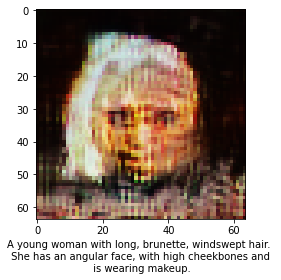

In [31]:
# run to generate first 100 images and save under images folder in collab
no  = 0
!mkdir images
for no in range(200):
    latent_space = np.random.normal(size =(1,latent_dim))
    # print(padded_doc[no].shape)
    out_put = generator.predict([latent_space,np.array([padded_doc[no]])])
    # disc_out = discriminator.predict([np.array([train_x[no]]),np.array([padded_docs[no]])])
    plt.imshow(out_put[0][0])
    # print(disc_out)
    # plt.text(20,73,docs[no])
    # plt.gcf().text(0.02, 0.5, docs[no], fontsize=14)
    i = 1
    text = []
    for x in docs[no].split(' '):
        if(i%9 == 0):
            text.append('\n')
        text.append(x)
        i = i +1
    plt.xlabel(" ".join(text))
    plt.tight_layout()
    plt.savefig('./images/'+str(no)+'.png')

plt.show()

In [32]:
!cp -r ./images drive/My\ Drive

In [33]:
 def make_example():
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 10
    rows = 10
    for i in range(1, columns*rows +1):
        latent_space = np.random.normal(size =(1,latent_dim))
        out_put = generator.predict([latent_space,np.array([padded_doc[i]])])
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(out_put[0][0],interpolation='nearest')
        plt.axis('off')
        i = 1
        text = []
        # for x in docs[no].split(' '):
        #     if(i%9 == 0):
        #         text.append('\n')
        #     text.append(x)
        #     i = i +1
        # plt.xlabel(" ".join(text))
        # plt.tight_layout()
    plt.savefig('images.png',bbox_inches='tight')

    plt.show()

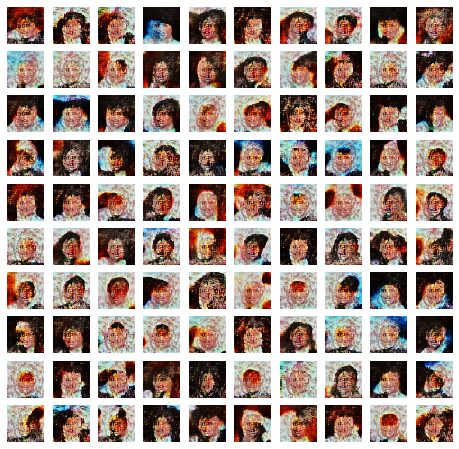

In [34]:
make_example()

1it [00:00, 1138.52it/s]

a girl with big oval face big eyes big nose big ears and a purple round specs
(1, 75, 50)


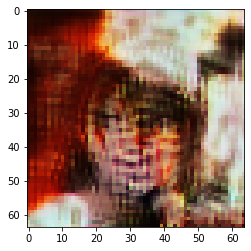

In [35]:
#for genrating img from custom txt
inp_encoded_docs = []
error_docs = []
inp_docs = ['a girl with big oval face big eyes big nose big ears and a purple round specs']
for sentence in tqdm(enumerate(inp_docs)):
    index,sentence = sentence
    print(sentence)
    sentence_list = []
    for word in re.split(r'[-,\s]\s*',sentence.lower()):
        word = word.translate(table)
        try:
            sentence_list.append(np.array(vocab_dict[word]))
        except:
            error_docs.append(index)
    inp_encoded_docs.append(np.array(sentence_list))
inp_padded_doc = []
x = inp_encoded_docs[0]
y =np.zeros((max_length-x.shape[0],50))
inp_padded_doc.append(np.concatenate([x,y],axis=0))
inp_padded_doc = np.array(inp_padded_doc)
print(inp_padded_doc.shape)
latent_space = np.random.normal(size =(1,latent_dim))

out_put = generator.predict([latent_space,np.array([inp_padded_doc[0]])])
plt.imshow(out_put[0][0])

A young eastern asian man with a toothy smile, looking sideways and wearing some traditional headwear.


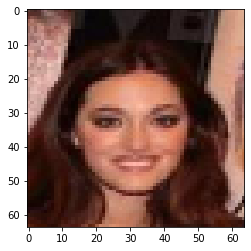

In [36]:
plt.imshow(data_images[70])
print(docs[800])
# print(data_images[1])

In [37]:
tf.keras.utils.plot_model(gan,to_file = 'gan.png',show_shapes=True)
tf.keras.utils.plot_model(discriminator,rankdir='LR',to_file = 'discriminator.png',show_shapes=True)
tf.keras.utils.plot_model(generator,rankdir='LR',to_file = 'generator.png',show_shapes=True)
tf.keras.utils.plot_model(encoder,to_file = 'encoder.png',show_shapes=True)

NameError: ignored

In [38]:
discriminator.save('drive/My Drive/Be project/discriminator-latest-2.h5')
generator.save('drive/My Drive/Be project/generator-latest-2.h5')

In [39]:
# RUN 16
generator = tf.keras.models.load_model('drive/My Drive/Be project/generator-latest-2.h5')

In [40]:
#for genrating img from custom txt
#    run 18 
def test(text = 'A woman with long, wavy, brunette hair, thick eyebrows, a round face and a wide smile.'):
    inp_encoded_docs = []
    error_docs = []
    inp_docs = [text]
    for sentence in tqdm(enumerate(inp_docs)):
        index,sentence = sentence
        # print(sentence)
        sentence_list = []
        for word in re.split(r'[-,\s]\s*',sentence.lower()):
            word = word.translate(table)
            try:
                sentence_list.append(np.array(vocab_dict[word]))
            except:
                error_docs.append(index)
        inp_encoded_docs.append(np.array(sentence_list))
    inp_padded_doc = []
    x = inp_encoded_docs[0]
    y =np.zeros((max_length-x.shape[0],50))
    inp_padded_doc.append(np.concatenate([x,y],axis=0))
    inp_padded_doc = np.array(inp_padded_doc)
    print(inp_padded_doc.shape)
    latent_space = np.random.normal(size =(1,latent_dim))

    out_put = generator.predict([latent_space,np.array([inp_padded_doc[0]])])
    plt.imshow(out_put[0][0])

1it [00:00, 315.50it/s]


(1, 75, 50)


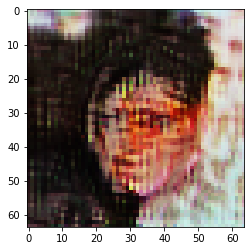

In [41]:
#    run 19 ,custom description
desc_1 = "A middle-aged  women with brown hair and small brown eyes. His lips are thin and he is smiling. He has got a square jaw."
# desc_1 += "He is smiling with visible upper teeth "
test(desc_1)